In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pyflann import *
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc
import cv2
import csv
import re
from sklearn.ensemble import RandomForestClassifier
import json
from tqdm import tqdm_notebook
import seaborn as sns

# %matplotlib notebook

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

project_dir="G:/My Drive/CRG_Dropbox/AljoComputer/Temp"
dir_keypoints="../expts/KeypointsAndDescriptors/validKeyPoints"
dir_descriptors="../expts/KeypointsAndDescriptors/descriptors"

C:\Users\Shaul\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from pathlib import Path
annotation_list = '../expts/annotation_list'
all_annotations = []
with open(annotation_list) as test_list:
    for annotation_file in test_list:
        annotation_file = project_dir + re.sub(".*/20180417_BG57_Midpoint_200micron_30fps/", "/", annotation_file.strip())
        with open(annotation_file) as fin_annotation:
            annotation = json.load(fin_annotation)
            all_annotations.extend(annotation["Annotations"])

print "len(all_annotations):", len(all_annotations)

gt = pd.DataFrame([])
descs = []
for ind, annotation in enumerate(all_annotations):
    parent, file_name = os.path.split(annotation['FrameFile'])
    file_name = os.path.splitext(file_name)[0]
    _, parent_name = os.path.split(parent)
    gt.loc[ind, 'FrameIndex'] = int(annotation['FrameIndexVideo'])
    gt.loc[ind, 'FileName'] = str(file_name.strip())
    gt.loc[ind, 'ParentName'] = str(parent_name.strip())
    for bp in annotation['FrameValueCoordinates']:
        if bp['Name'] == 'LeftDorsalOrgan':
            if (bp['Value']['x_coordinate'] != -1) and (bp['Value']['y_coordinate'] != -1):
                gt.loc[ind, 'LeftDorsalOrgan'] = 1
            else:
                gt.loc[ind, 'LeftDorsalOrgan'] = 0
        elif bp['Name'] == 'RightDorsalOrgan':
            if (bp['Value']['x_coordinate'] != -1) and (bp['Value']['y_coordinate'] != -1):
                gt.loc[ind, 'RightDorsalOrgan'] = 1
            else:
                gt.loc[ind, 'RightDorsalOrgan'] = 0
    desc_file = os.path.join(dir_descriptors, str(parent_name.strip()), str(file_name.strip() + '.csv'))
    try:
        temp = pd.read_csv(desc_file, sep='\t', header=None)
        descs.append(temp.values)
    except:
        temp = pd.DataFrame(np.zeros((1, 128)))
        descs.append(temp.values)
        continue

print "len(descs):", len(descs)        

len(all_annotations): 2613
len(descs): 2613


CrossVal Round 1
Training.......



Testing.......



CrossVal Round 2
Training.......



Testing.......



CrossVal Round 3
Training.......



Testing.......



CrossVal Round 4
Training.......



Testing.......



CrossVal Round 5
Training.......



Testing.......


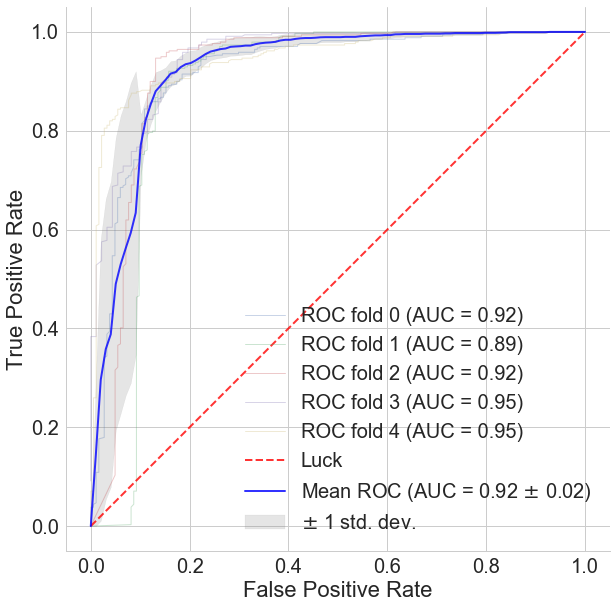

In [3]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scipy import interp

X = gt.index.values
y = gt.loc[:, 'LeftDorsalOrgan']
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
cv = StratifiedKFold(n_splits=5)
sns.set(style="whitegrid", font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Best parameters based on gridSearch are 64 and 100
# rf = RandomForestClassifier(max_depth=64, n_estimators=128, n_jobs=16)
# rf = RandomForestClassifier(max_depth=32, n_estimators=64, n_jobs=16)
# rf = RandomForestClassifier(max_depth=16, n_estimators=32, n_jobs=16)
rf = RandomForestClassifier(max_depth=8, n_estimators=16, n_jobs=16)
# rf = RandomForestClassifier(max_depth=4, n_estimators=16, n_jobs=16)

cnt = 0
for train, test in cv.split(X, y):
    print('CrossVal Round', cnt+1)
    train_desc = np.zeros((0,128))
    train_labels = np.zeros((0,1))
    print('Training.......')
    for i in tqdm_notebook(train):
        train_desc = np.r_[train_desc, descs[i]]
        train_labels = np.r_[train_labels, np.tile(gt.loc[i, 'LeftDorsalOrgan'], (np.shape(descs[i])[0], 1))]
    rf.fit(train_desc, np.ravel(train_labels))
    
    print('Testing.......')
    test_desc = np.zeros((0,128))
    test_labels = np.zeros((0,1))
    probas_ = []
    for i in tqdm_notebook(test):
        pred = rf.predict(descs[i])
        probas_.append(np.mean(pred))
        test_labels = np.r_[test_labels, np.reshape(np.array([gt.loc[i, 'LeftDorsalOrgan']]), (1,1))]

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(test_labels, np.array(probas_))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (cnt, roc_auc))
    cnt += 1

tprs_mat = np.array(tprs)
tprs_mat.dump("tprs_mat_LDO_depth8.dat")

aucs_mat = np.array(aucs)
aucs_mat.dump("aucs_mat_LDO_depth8.dat")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", frameon=False)
sns.despine()
plt.axis('scaled')
plt.savefig("CrossVal_ROC_10_Fold_LDO_depth8.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig("CrossVal_ROC_10_Fold_LDO_depth8.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

CrossVal Round 1
Training.......



Testing.......



CrossVal Round 2
Training.......



Testing.......



CrossVal Round 3
Training.......



Testing.......



CrossVal Round 4
Training.......



Testing.......



CrossVal Round 5
Training.......



Testing.......


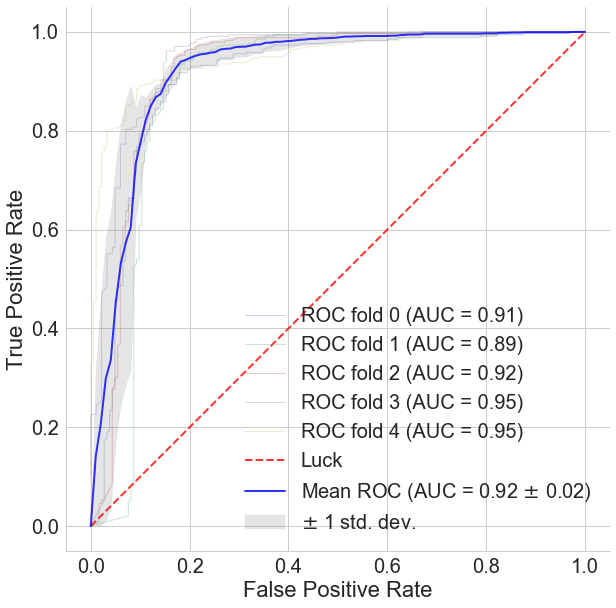

In [4]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scipy import interp

X = gt.index.values
y = gt.loc[:, 'RightDorsalOrgan']
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
cv = StratifiedKFold(n_splits=5)
sns.set(style="whitegrid", font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Best parameters based on gridSearch are 64 and 100
# rf = RandomForestClassifier(max_depth=64, n_estimators=128, n_jobs=16)
# rf = RandomForestClassifier(max_depth=32, n_estimators=64, n_jobs=16)
# rf = RandomForestClassifier(max_depth=16, n_estimators=32, n_jobs=16)
rf = RandomForestClassifier(max_depth=8, n_estimators=16, n_jobs=16)
# rf = RandomForestClassifier(max_depth=4, n_estimators=16, n_jobs=16)

cnt = 0
for train, test in cv.split(X, y):
    print('CrossVal Round', cnt+1)
    train_desc = np.zeros((0,128))
    train_labels = np.zeros((0,1))
    print('Training.......')
    for i in tqdm_notebook(train):
        train_desc = np.r_[train_desc, descs[i]]
        train_labels = np.r_[train_labels, np.tile(gt.loc[i, 'RightDorsalOrgan'], (np.shape(descs[i])[0], 1))]
    rf.fit(train_desc, np.ravel(train_labels))
    
    print('Testing.......')
    test_desc = np.zeros((0,128))
    test_labels = np.zeros((0,1))
    probas_ = []
    for i in tqdm_notebook(test):
        pred = rf.predict(descs[i])
        probas_.append(np.mean(pred))
        test_labels = np.r_[test_labels, np.reshape(np.array([gt.loc[i, 'RightDorsalOrgan']]), (1,1))]

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(test_labels, np.array(probas_))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (cnt, roc_auc))
    cnt += 1

tprs_mat = np.array(tprs)
tprs_mat.dump("tprs_mat_RDO_depth8.dat")

aucs_mat = np.array(aucs)
aucs_mat.dump("aucs_mat_RDO_depth8.dat")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", frameon=False)
sns.despine()
plt.axis('scaled')
plt.savefig("CrossVal_ROC_10_Fold_RDO_depth8.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig("CrossVal_ROC_10_Fold_RDO_depth8.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
print(asfasfag)

NameError: name 'asfasfag' is not defined

In [ ]:
from __future__ import print_function

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from scipy import interp

X = gt.index.values
y = gt.loc[:, 'LeftDorsalOrgan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

nsplits = 3
cv = StratifiedKFold(n_splits=nsplits)

# Set the parameters by cross-validation
tuned_parameters = {'max_depth': [16, 32, 64, 128, 256],
                     'n_estimators': [1, 10, 100, 1000]}

scores = ['precision', 'recall']

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

tprs = []

grid_precision = np.zeros((nsplits, len(tuned_parameters['max_depth']),
                      len(tuned_parameters['n_estimators'])))
grid_recall = np.zeros((nsplits, len(tuned_parameters['max_depth']),
                      len(tuned_parameters['n_estimators'])))
grid_f1 = np.zeros((nsplits, len(tuned_parameters['max_depth']),
                      len(tuned_parameters['n_estimators'])))
grid_auc = np.zeros((nsplits, len(tuned_parameters['max_depth']),
                      len(tuned_parameters['n_estimators'])))

sp = -1
for train, test in cv.split(X_train, y_train):
    sp += 1
    train_desc = np.zeros((0,128))
    train_labels = np.zeros((0,1))
    for i in train:
        train_desc = np.r_[train_desc, descs[i]]
        train_labels = np.r_[train_labels, np.tile(gt.loc[i, 'LeftDorsalOrgan'], (np.shape(descs[i])[0], 1))]
    
    for i_est, est in enumerate(tuned_parameters['n_estimators']):
        for i_dep, dep in enumerate(tuned_parameters['max_depth']):
            rf = RandomForestClassifier(max_depth=dep, n_estimators=est)
            rf.fit(train_desc, np.ravel(train_labels))
            
            test_desc = np.zeros((0,128))
            test_labels = np.zeros((0,1))
            probas_ = []
            for i in test:
                pred = rf.predict(descs[i])
                probas_.append(np.mean(pred))
                test_labels = np.r_[test_labels, np.reshape(np.array([gt.loc[i, 'LeftDorsalOrgan']]), (1,1))]

            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(test_labels, np.array(probas_))
            grid_auc[sp, i_dep, i_est] = auc(fpr, tpr)
            
#             prec, recl, f1, _ = precision_recall_fscore_support(test_labels, np.array(probas_), average='weighted')
#             grid_precision[sp, i_dep, i_est] = prec.copy()
#             grid_precision[sp, i_dep, i_est] = recl.copy()
#             grid_precision[sp, i_dep, i_est] = f1.copy()

grid_auc.dump("grid_auc_10.dat")
mat2 = np.load("grid_auc_10.dat")

In [ ]:
# df = pd.DataFrame(np.c_[thresholds.T, fpr.T, tpr.T], columns=['Threshold', 'FPR', 'TPR'])
# df.loc[:, 'FPR'] = df.loc[:, 'FPR'].copy()*100
# df.loc[:, 'TPR'] = df.loc[:, 'TPR'].copy()*100
# df.loc[:, ['TPR', 'FPR']] = df.loc[:, ['TPR', 'FPR']].round(0).copy()
# tol_cutoff = 10.0

# optimal_votes = df[df['FPR'] == tol_cutoff].iloc[0, 0]
# optimal_tpr = df[df['FPR'] == tol_cutoff].iloc[0, 2]
# optimal_fpr = df[df['FPR'] == tol_cutoff].iloc[0, 1]

# print 'Optimal votes at %d percent FPR : %0.2f '%(optimal_fpr, optimal_votes) 
# print 'TPR at Optimal votes : ', optimal_tpr


In [ ]:
# det = np.zeros_like(votes_use)
# pos_frames = np.where(votes_use >= optimal_votes)
# neg_frames = np.where(votes_use < optimal_votes)
# det[pos_frames] = 1

In [ ]:
# out_vid = 'temp.avi'
# video_crop = cv2.VideoWriter(out_vid, 0, 5, (1920, 1920))
# cap = cv2.VideoCapture(video_file)

# first_frame = gt.index.values[0]
# ind = -1
# for frame_index, row in gt.iterrows():
#     ind += 1
#     if cap.isOpened():
#         cap.set(1, frame_index)
#         ret, frame = cap.read()
#         if (ret == True):
#             if votes_use[ind] >= optimal_votes:
#                 cv2.circle(frame, (1800, 200), radius=30, color=(0, 255, 0), thickness=-1)
#             else:
#                 cv2.circle(frame, (1800, 200), radius=30, color=(0, 0, 255), thickness=-1)

#             video_crop.write(frame)
#     else:
#         print 'Cap Not Opened'
#         cap.release()

# cap.release()
# cv2.destroyAllWindows()
# video_crop.release()

In [ ]:
# gt = {}
# fpr = {}
# tpr = {}
# thresholds = {}
# roc_auc = {}

# train_data_pos = get_train_data(train_pos.copy())
# train_data_neg = get_train_data(train_neg.copy())

# fig_roc = plt.figure(figsize=(14, 12))
# patch_sizes = np.arange(4, 17, 2)
# patch_sigmas = np.arange(0.1, 11, 1)
# detected_loc = {}
# for vote_patch in patch_sizes:
#     for vote_sigma in patch_sigmas:
#         detected_loc = predict_locations_patchsize(train_data_pos, test_annotations, vote_patch, vote_sigma)
#         gt, fpr, tpr, thresholds, roc_auc = plot_roc_curve_metrics(detected_loc, no_anno_df, ['Sum'])
#         plt.plot(fpr, tpr, lw=2, label='R-%d S-%d (AUC = %0.2f)'%(vote_patch, vote_sigma, roc_auc))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # plt.title(bp)
# plt.legend(loc="lower right", frameon=False)
# plt.show()

In [ ]:
# train_data_pos = get_train_data(train_pos.copy())
# detected_loc = predict_locations(train_data_pos, test_annotations)

# ground_truth = detected_loc.iloc[:, 17:].astype(dtype=np.uint16).copy()
# ground_truth.loc[:, :] = 1
# for rind, rval in no_anno_df.iterrows():
#     if rval['index'] in detected_loc.index.values:
#         ground_truth.loc[rval['index'], rval['col']+'_votes'] = 0
# votes_use = detected_loc.iloc[:, 17:].astype(dtype=np.float32).copy()
    
# y_true = ground_truth['LeftDorsalOrgan_votes'].values
# y_score = votes_use['LeftDorsalOrgan_votes'].values

# # make y_true a boolean vector
# y_true = (y_true == 1)

# # sort scores and corresponding truth values
# desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
# y_score = y_score[desc_score_indices]
# y_true = y_true[desc_score_indices]
# weight = 1.

# # y_score typically has many tied values. Here we extract
# # the indices associated with the distinct values. We also
# # concatenate a value for the end of the curve.
# distinct_value_indices = np.where(np.diff(y_score))[0]
# threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

# # accumulate the true positives with decreasing threshold
# # tps = stable_cumsum(y_true * weight)[threshold_idxs]
# tps = np.cumsum(y_true * weight)[threshold_idxs]
# fps = 1 + threshold_idxs - tps

# # return fps, tps, y_score[threshold_idxs]

# fpr = fps / fps[-1]
# tpr = tps / tps[-1]


In [ ]:
# temp_coordinates = all_coordinates.loc[:, all_coordinates.columns.values[::2]]
# total_negatives = temp_coordinates[temp_coordinates<0].count()
# total_positives = temp_coordinates[temp_coordinates>=0].count()
# posneg_df = pd.DataFrame([total_positives, total_negatives])
# posneg_df.columns = distance_header
# posneg_df.index = ['pos', 'neg']
# posneg_df

In [ ]:
# vote_patch_size = 30
# vote_sigma = 15
# bodypart_vote = np.zeros((2 * vote_patch_size + 1, 2 * vote_patch_size + 1), np.float)

# for x in range(-vote_patch_size, vote_patch_size + 1):
#     for y in range(-vote_patch_size, vote_patch_size + 1):
#         bodypart_vote[y + vote_patch_size, x + vote_patch_size] = np.exp(-0.5 * (
#             x * x + y * y) / (np.square(vote_sigma))) / (vote_sigma * np.sqrt(2 * np.pi))

# imgplot = plt.imshow(bodypart_vote, cmap="hot")
# plt.colorbar()